# Idea

Set up the data in matrix form as day/store for each family. Then use SVD as a preprocessing step to pool data across stores. The idea here is to use a low-rank approximation of the original data, which is likely to reduce the noise due to the fact that the most important eigenvalues from the SVD should be related to the actual signal in the data, so it is used as a sort of denoising technique.

In [1]:
from storeSalesUtils.dataloading import load_stores, load_train, load_holidays, load_test, load_oil, DATA_FOLDER
from storeSalesUtils.plotting import plot_joint_plot, plot_autocorrelations
from storeSalesUtils.prophetPipeline import (prophetPipeline, parse_holidays, parse_oil_prophet,
                                      visualize_forecasts, RMSLE, grangers_causation_matrix)

import pandas as pd
from pandas.errors import SettingWithCopyWarning
import numpy as np
from numpy.linalg import svd
import os
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, grangercausalitytests

import logging
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

from tqdm.auto import tqdm

import warnings
warnings.simplefilter("ignore", SettingWithCopyWarning)
warnings.simplefilter("ignore", FutureWarning)

plt.rcParams["figure.figsize"] = (16, 4)

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
train = load_train()
stores = load_stores()
holidays = load_holidays()
oil = load_oil()
oil_prophet = parse_oil_prophet(oil)

test = load_test()

# only use two years of data available
maxDate = train.date.max()
minDate = maxDate - pd.DateOffset(years=2)
print('Using data within the dates: ', maxDate, minDate)
train = train[train.date.between(minDate, maxDate)]

# simulate test set scenario using the last 15 days of data for validation
val_dates = maxDate - pd.DateOffset(15)
train['split'] = np.where(train.date>=val_dates, 'validation', 'train')

train.head()

Using data within the dates:  2017-08-15 00:00:00 2015-08-15 00:00:00


,id,date,store_nbr,family,sales,onpromotion,split
1700028,1700028,2015-08-15,1,AUTOMOTIVE,3.0,0,train
1700029,1700029,2015-08-15,1,BABY CARE,0.0,0,train
1700030,1700030,2015-08-15,1,BEAUTY,0.0,0,train
1700031,1700031,2015-08-15,1,BEVERAGES,2845.0,5,train
1700032,1700032,2015-08-15,1,BOOKS,0.0,0,train


In [19]:
family = 'AUTOMOTIVE'

train_dataMatrix = train[(train.split=='train') & (train.family==family)]

train_dataMatrix = train_dataMatrix.pivot_table(values='sales', index='date', columns='store_nbr')
train_dataMatrix.columns = train_dataMatrix.columns.astype(str)

# we predict the square root of sales to get non-negative values in the end,
# since the low rank approximation might be negative
sqrt_sales = train_dataMatrix.apply(np.sqrt)

# standardize data
sqrt_store_means = sqrt_sales.mean()
sqrt_store_stds = sqrt_sales.std()
sqrt_sales = (sqrt_sales - sqrt_store_means)/sqrt_store_stds

print(sqrt_sales.shape)
sqrt_sales.head()

(714, 54)


store_nbr,1,2,3,4,5,6,7,8,9,10,...,45,46,47,48,49,50,51,52,53,54
date,,,,,,,,,,,,,,,,,,,,,
2015-08-15,-0.147898,-0.567470,1.157934,0.419323,0.870358,-0.067953,0.662871,-0.610398,1.391460,0.837046,...,0.837349,0.703314,-1.304924,1.761371,0.267364,-0.226815,1.227740,-0.390328,-0.605871,-0.497530
2015-08-16,-1.047612,0.930601,-0.488257,0.419323,0.629013,-0.363857,0.892350,1.106527,0.177570,-0.137772,...,0.731392,0.485151,0.596543,2.109214,1.111454,-1.010367,0.012734,-0.390328,-1.448843,1.286623
2015-08-17,-2.276644,-0.912832,-1.452573,0.114415,-0.536300,-1.098122,0.662871,-0.005347,-0.113552,0.239221,...,-0.649448,-0.395137,-0.163965,-0.265812,-0.229303,-0.590162,-0.505883,-0.390328,-1.448843,-0.840502
2015-08-18,1.609897,-0.567470,-0.929352,-1.177199,-1.360301,-0.363857,-0.484929,-0.288737,-0.971902,0.239221,...,0.837349,1.109079,-0.606471,-0.420313,-1.027948,0.925135,-0.505883,-0.390328,-2.899394,-1.691563
2015-08-19,0.181420,2.761237,0.080021,1.406028,0.870358,0.674551,-0.884199,-0.005347,0.315315,-1.815200,...,-0.222235,-1.032882,0.596543,-0.757585,0.267364,-1.853329,-1.546265,-0.390328,-0.605871,0.097680


In [20]:
u, s, vh = svd(sqrt_sales, full_matrices=True)
u.shape, s.shape, vh.shape

((714, 714), (54,), (54, 54))

In [21]:
u[:, :10].shape

(714, 10)

In [22]:
cumulative_comps = s.cumsum()/s.sum()

# select the number of components which account for some threshold of the cumulative singular values
thresh = 0.5
lowRank_components = np.where(cumulative_comps>thresh)[0][0]
train_lowRank = np.dot(u[:, :lowRank_components] * s[:lowRank_components], vh[:lowRank_components, :])

train_lowRank = pd.DataFrame(train_lowRank, index=train_dataMatrix.index, columns=train_dataMatrix.columns)

# we want to ignore streaks of consecutive zeros, so we set this to NaN
aux = pd.DataFrame(np.where(train_dataMatrix.rolling(7).mean() == 0, np.nan, 1), index=train_lowRank.index, columns=train_lowRank.columns)
train_lowRank = train_lowRank * aux

train_lowRank['total'] = train_lowRank.sum(axis=1)
train_lowRank.head()

store_nbr,1,2,3,4,5,6,7,8,9,10,...,46,47,48,49,50,51,52,53,54,total
date,,,,,,,,,,,,,,,,,,,,,
2015-08-15,-0.599525,-0.097898,0.378644,0.350277,0.804292,0.395950,0.505283,-0.622772,1.348480,-0.541436,...,0.716974,0.401201,1.740816,0.566101,0.352086,0.674846,-0.120484,-1.355673,-0.383576,11.170001
2015-08-16,-1.153510,1.407377,0.057169,0.688844,0.222716,0.488512,1.390768,0.502925,0.389003,0.183523,...,0.486521,0.736941,1.081976,0.166456,-0.064709,-0.206611,-0.553862,-0.945699,0.366636,4.613303
2015-08-17,-1.574829,-0.525738,-1.349617,0.977347,-0.542563,-1.077147,0.776775,-0.152551,0.207498,0.386836,...,-0.363603,-0.444751,0.091117,-0.782941,-0.479733,-0.235352,-0.168593,-1.493460,-0.431964,-20.385679
2015-08-18,1.157739,-0.692924,-0.822113,-0.541573,-0.148028,-0.475474,-0.253956,-0.226171,-0.285935,0.258481,...,-0.017488,-0.230741,0.149554,-0.338384,-0.514903,-0.493332,-0.899086,-2.338282,-0.982937,-19.852519
2015-08-19,0.064801,2.113457,0.554630,0.395131,0.055828,0.008924,0.241739,-0.235344,0.150637,-1.810802,...,-0.527028,-0.180054,-0.108206,0.648888,-0.966868,-1.919581,-0.671075,-0.693424,-0.696726,-19.058690


<AxesSubplot: xlabel='date'>

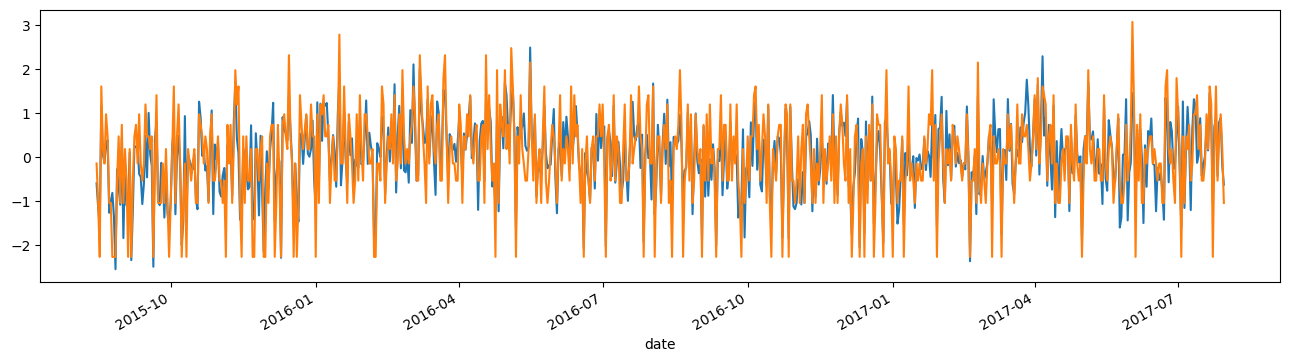

In [23]:
train_lowRank['1'].plot()
sqrt_sales['1'].plot()

In [9]:
from hts.hierarchy import HierarchyTree
from hts.model import FBProphetModel
from hts import HTSRegressor

In [24]:
stores = train_lowRank.drop('total', axis=1).columns.to_list()

hierarchy = {
    'total': stores,
}
stores_dict = dict(zip(stores, [[s] for s in stores]))

hierarchy = {**hierarchy}
# hierarchy

In [25]:
reg = HTSRegressor(model='prophet', revision_method='OLS', **{'yearly_seasonality':True, 'weekly_seasonality':True})
reg = reg.fit(df=train_lowRank, nodes=hierarchy, show_warnings=False)

Fitting models:   0%|                                | 0/19 [00:00<?, ?it/s]INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:f

In [26]:
preds = reg.predict(steps_ahead=16)

Fitting models: 100%|███████████████████████| 19/19 [02:39<00:00,  8.42s/it]


In [27]:
# # set up mean and std as the ones from the actual data matrix
# prev_15 = train_dataMatrix[train_dataMatrix.index >= pd.to_datetime('2017-07-14')]

# go back to actual scale of values in square root sales
adjusted_preds = (preds.drop('total', axis=1)*sqrt_store_stds)+sqrt_store_means
# adjusted_preds = (preds.drop('total', axis=1)*prev_15.std())+prev_15.mean()

# go from square root of sales to actual sales
adjusted_preds = adjusted_preds.apply(lambda x: np.power(x, 2))

adjusted_preds.describe()

,1,2,3,4,5,6,7,8,9,10,...,45,46,47,48,49,50,51,52,53,54
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,7.300000e+02,...,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,7.300000e+02,730.000000,730.000000
mean,3.415208,5.925139,10.453436,3.637747,5.645574,5.152575,4.679006,5.043430,287.659265,2.755903e+00,...,15.553547,13.991014,15.025099,11.632141,11.217549,10.344620,6.815726,3.856029e-01,14.452403,6.699413
std,0.992072,1.523517,2.299755,1.319603,1.304503,0.962649,2.072289,1.795360,397.234340,1.629286e+00,...,2.592633,5.045027,1.831277,2.164822,1.643319,2.651694,0.782223,4.043442e-01,5.375521,1.881340
min,1.100032,1.952177,4.814651,0.455066,1.995200,2.687004,0.320427,1.218783,0.000117,2.059252e-07,...,9.704436,4.428277,10.929121,6.597146,7.034294,4.737156,4.870503,4.193367e-08,3.372509,2.958610
25%,2.688308,4.863597,8.663050,2.572538,4.663608,4.434250,2.774012,3.685081,15.157459,1.114919e+00,...,13.695574,10.446491,13.674692,10.074243,10.247646,8.760181,6.282153,7.130676e-02,9.895326,4.968820
50%,3.369952,5.915062,10.554951,3.737938,5.829232,5.132818,4.909203,5.103501,81.495667,3.208497e+00,...,15.424381,12.953458,14.917096,11.858622,11.024467,10.329076,6.801055,2.531325e-01,14.163842,6.819157
75%,4.069347,7.150786,12.003173,4.718025,6.693727,5.844225,6.387398,6.283207,462.743060,4.024311e+00,...,17.517729,18.643108,16.023613,13.309823,12.005144,11.818641,7.287121,5.780680e-01,18.969563,8.526367
max,6.721964,9.512059,16.357962,6.379341,8.868762,7.511958,8.835221,10.557246,1698.779667,5.547052e+00,...,21.422654,25.264540,20.193967,16.451642,17.025714,17.766074,8.700408,2.147013e+00,27.561727,9.944865


In [28]:
validation_dataMatrix = train[(train.split=='validation') & (train.family==family)]

validation_dataMatrix = validation_dataMatrix.pivot_table(values='sales', index='date', columns='store_nbr')
validation_dataMatrix.columns = validation_dataMatrix.columns.astype(str)

print(validation_dataMatrix.shape)

val_assessment = adjusted_preds.loc[validation_dataMatrix.index.min():validation_dataMatrix.index.max(), :]

val_assessment = val_assessment.melt(ignore_index=False).reset_index()
val_assessment.columns = ['date', 'store_nbr', 'pred']
val_assessment['store_nbr'] = val_assessment.store_nbr.astype(int)

aux = train[(train.split=='validation') & (train.family==family)][['date', 'store_nbr', 'sales']]

val_assessment = val_assessment.merge(aux, on=['date', 'store_nbr'])

RMSLE(val_assessment.pred, val_assessment.sales)

(16, 54)


0.745

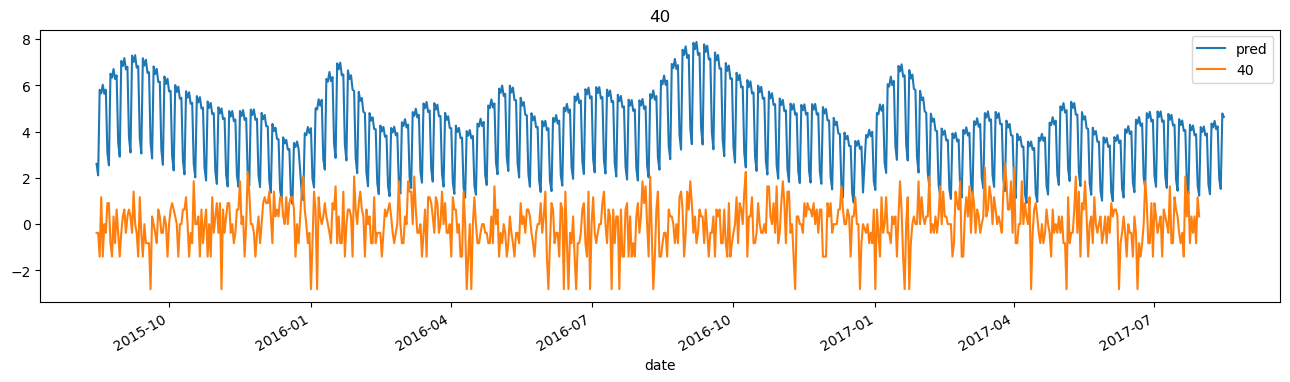

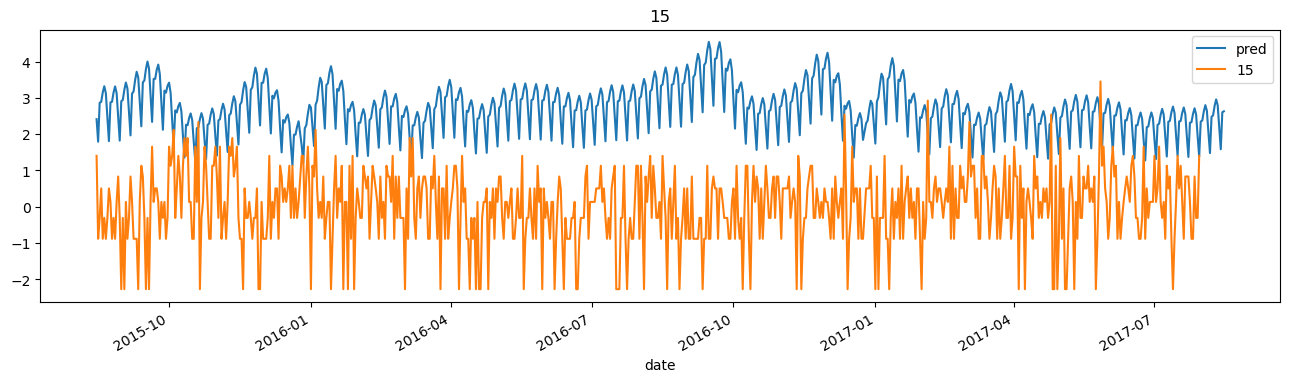

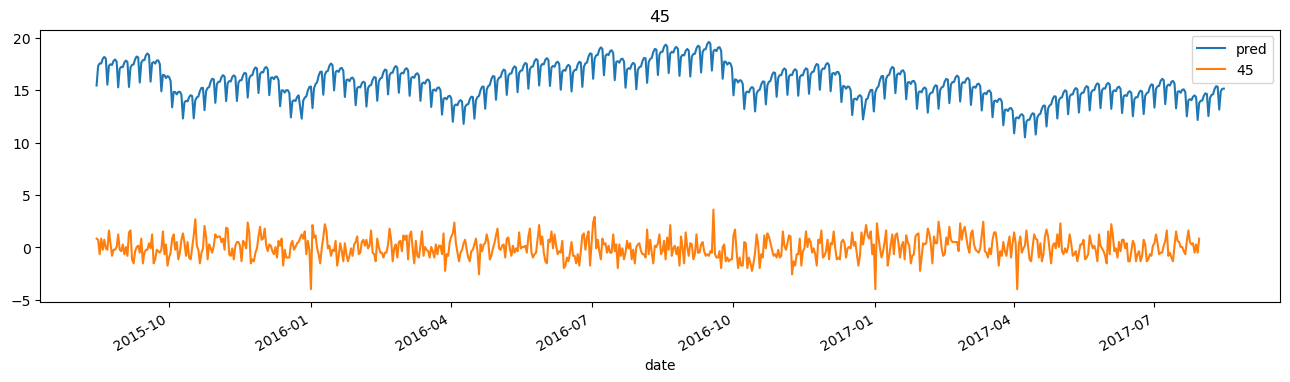

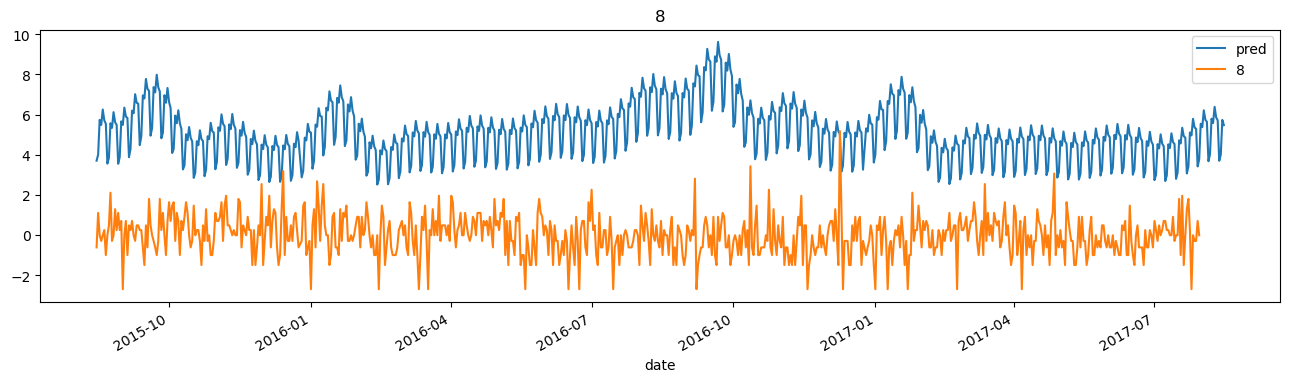

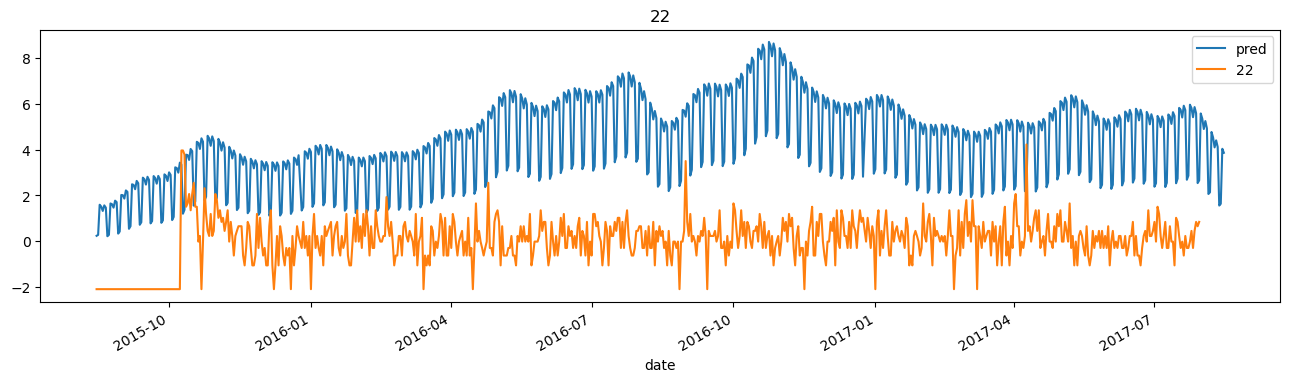

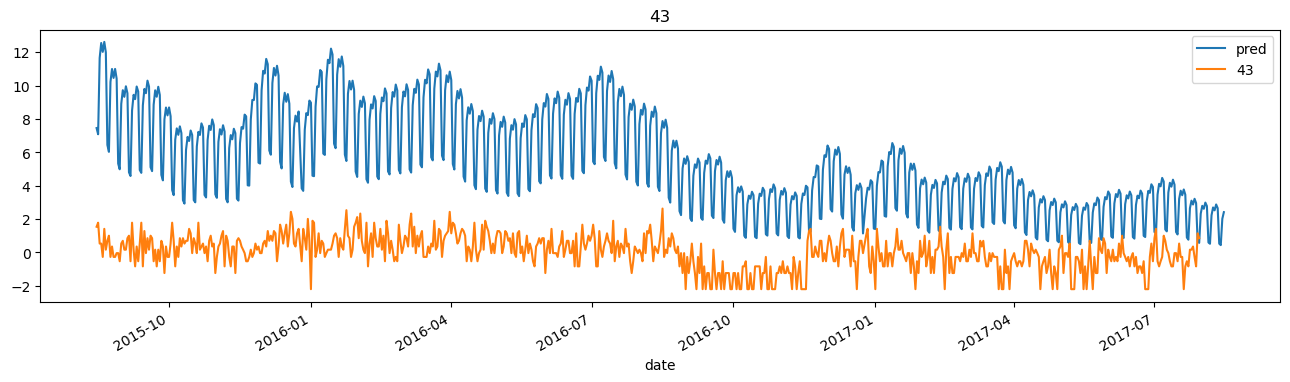

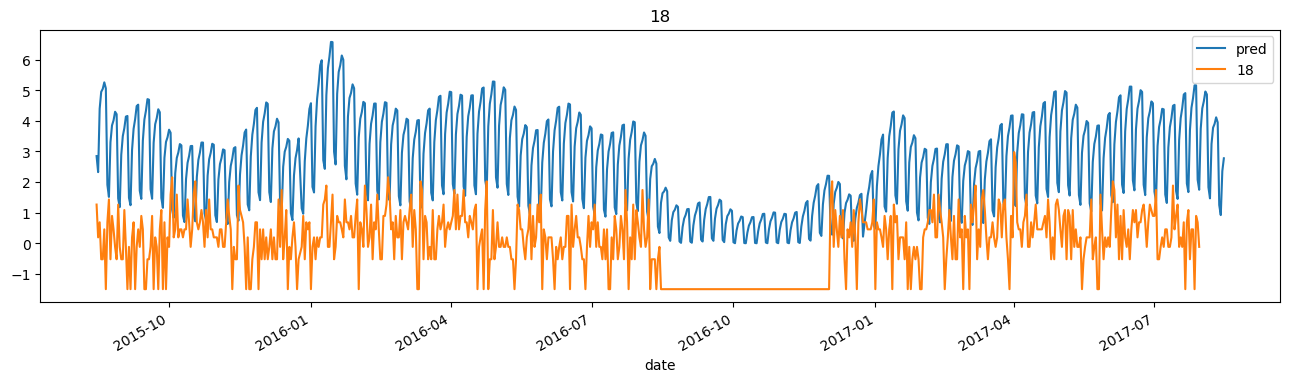

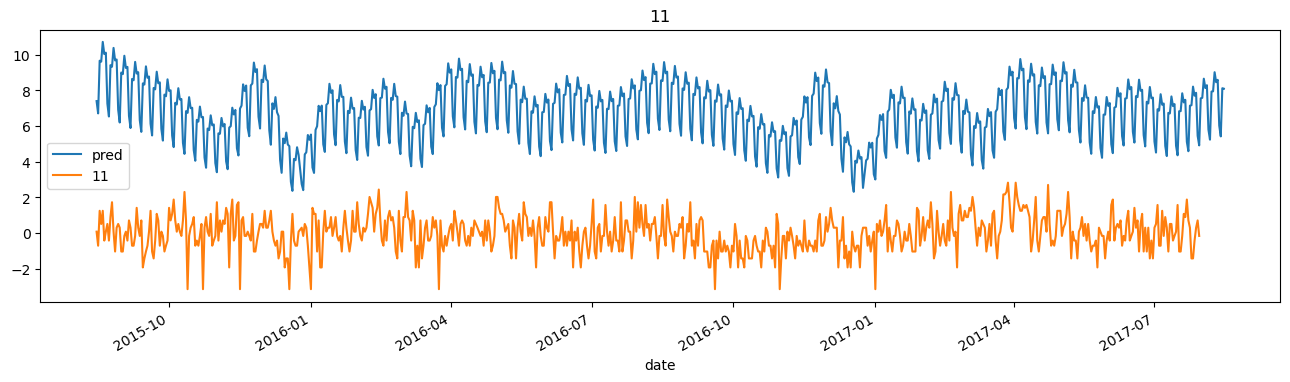

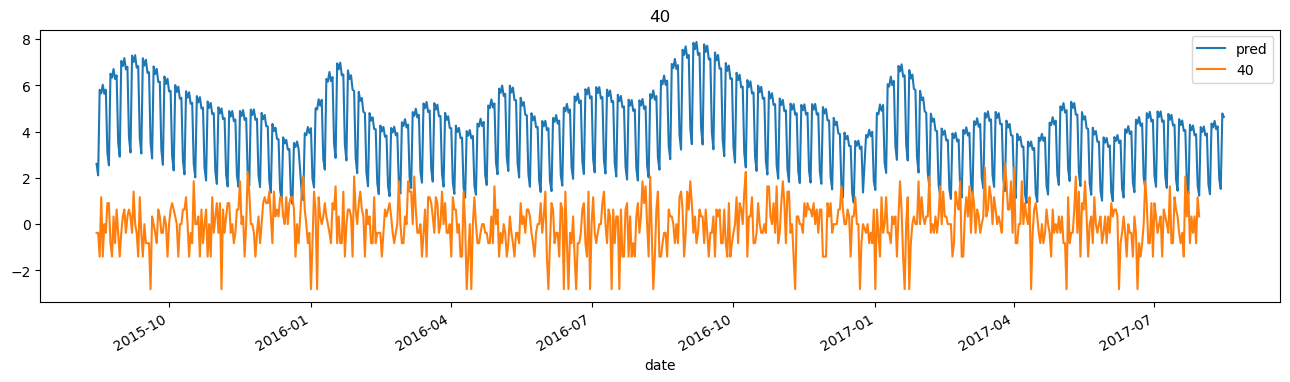

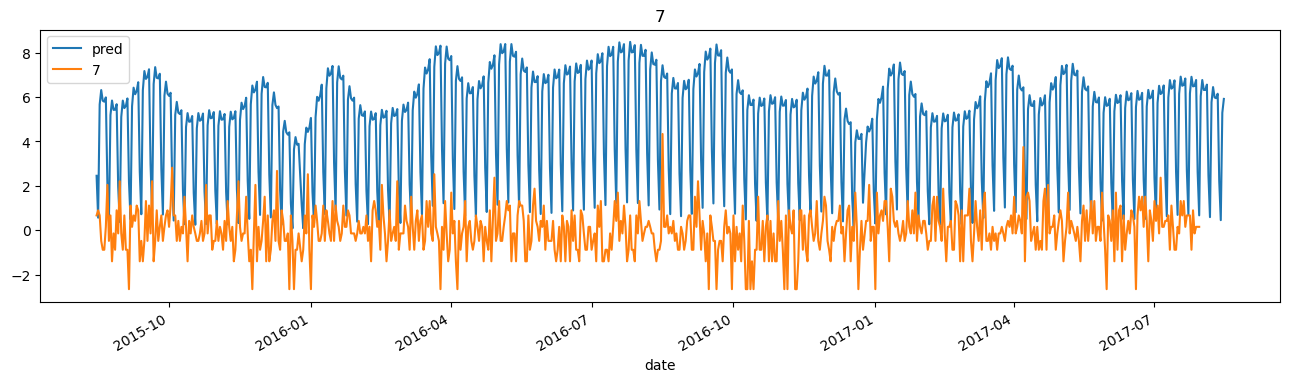

In [ ]:
np.random.seed(2)
sample = np.random.randint(0, len(train_lowRank.columns), 10)
sample = [str(col) for col in sample]

for col in sample:
    if col != 'total':
        ax = adjusted_preds[col].plot(label='pred')
        train_dataMatrix[col].plot(ax=ax)
        # train_lowRank[col].plot(ax=ax)
        ax.set_title(col)
        plt.legend()
        plt.show()

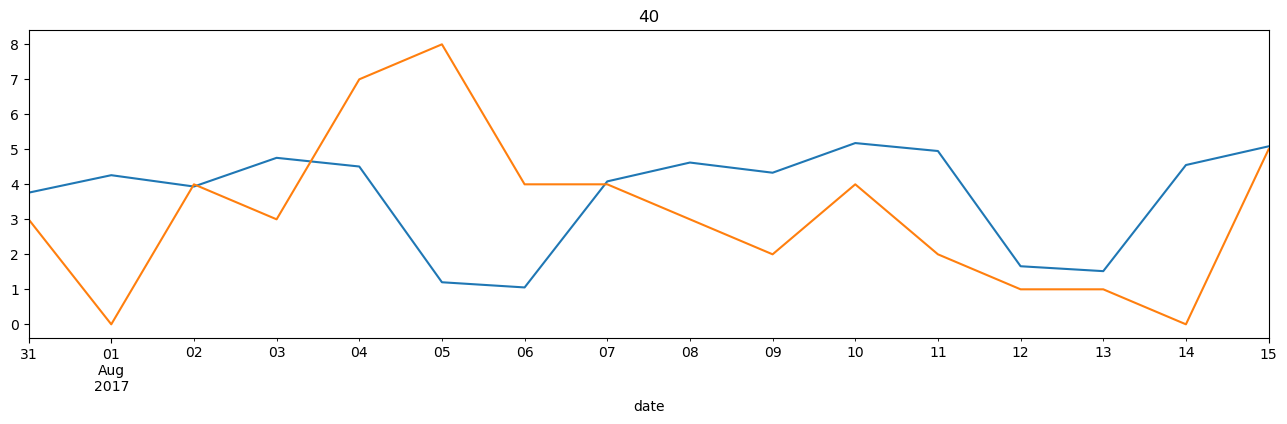

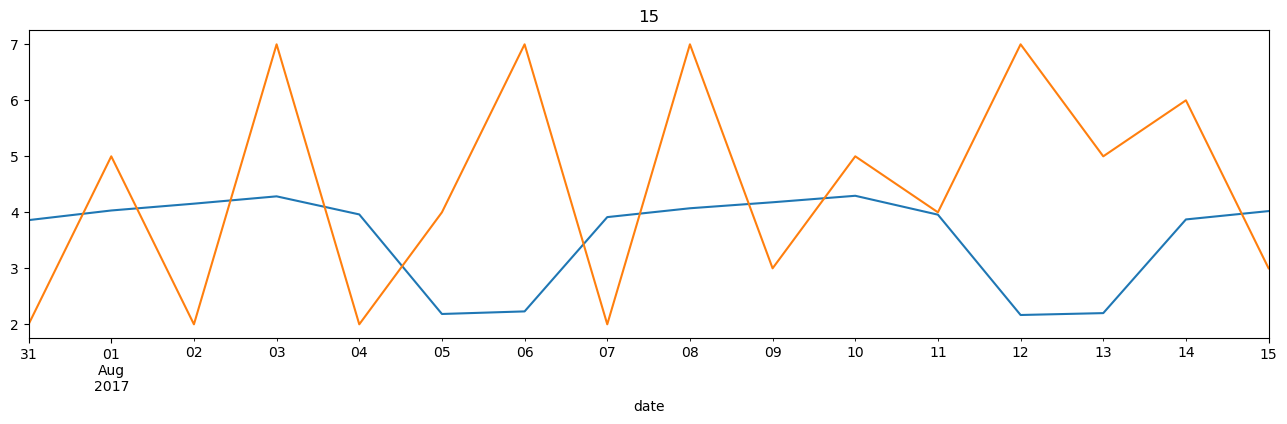

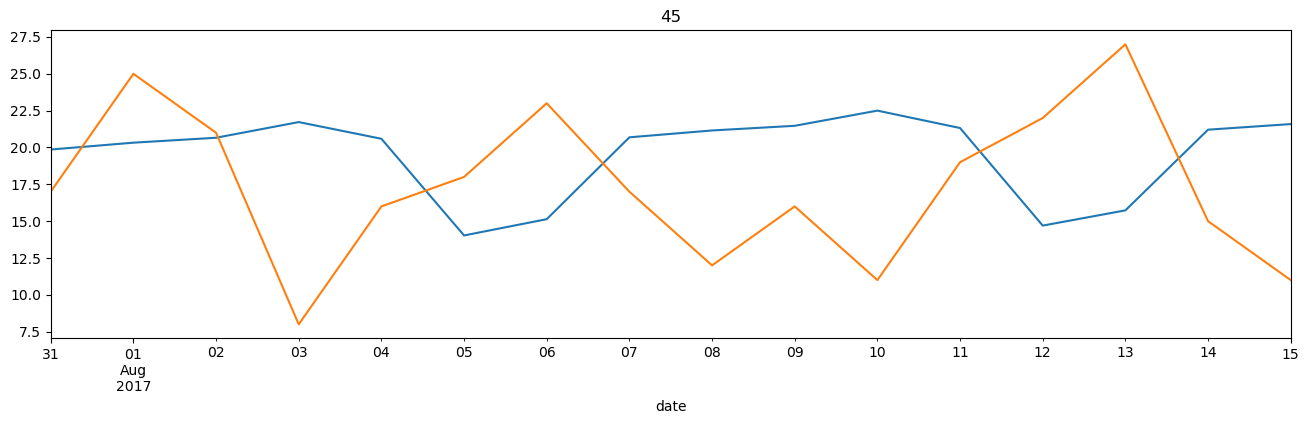

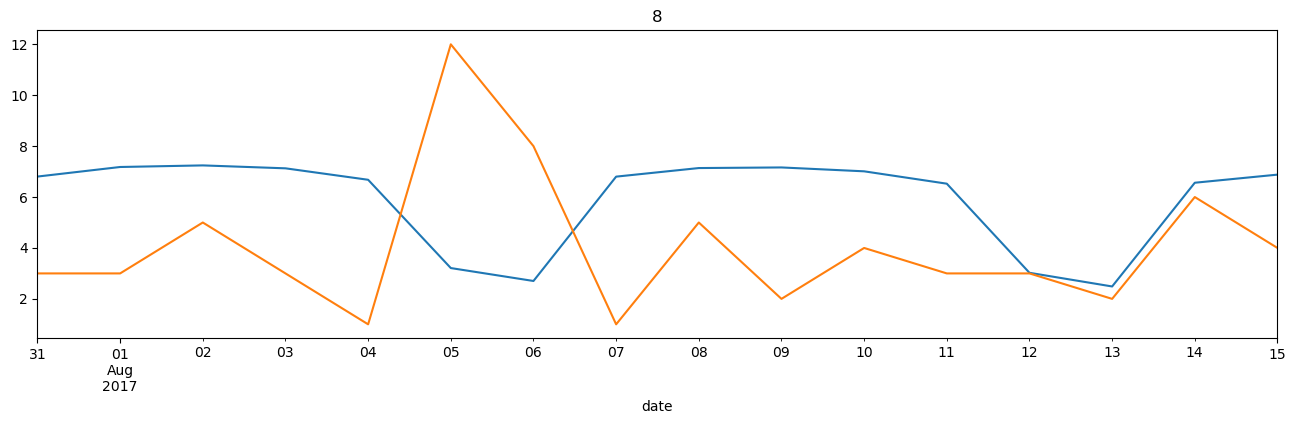

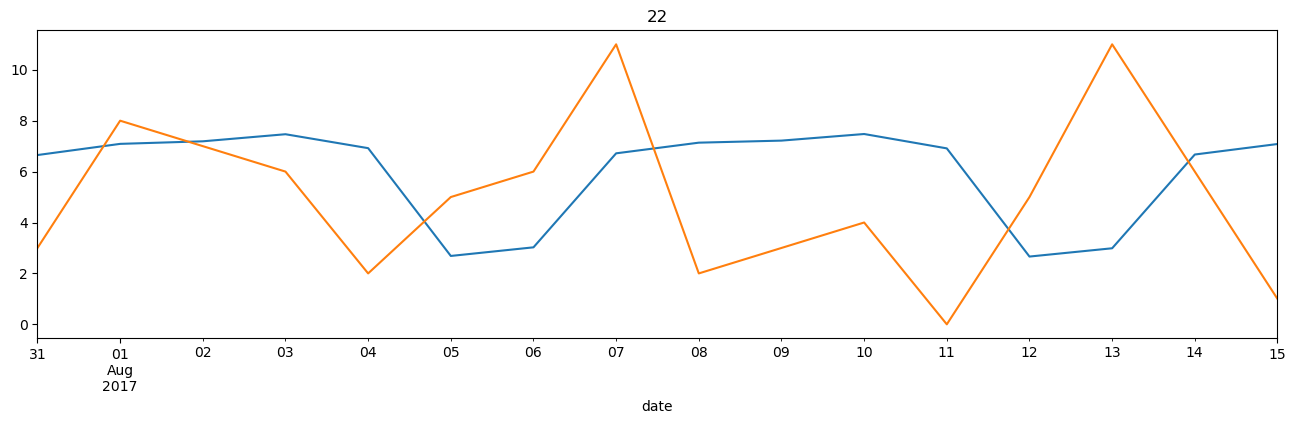

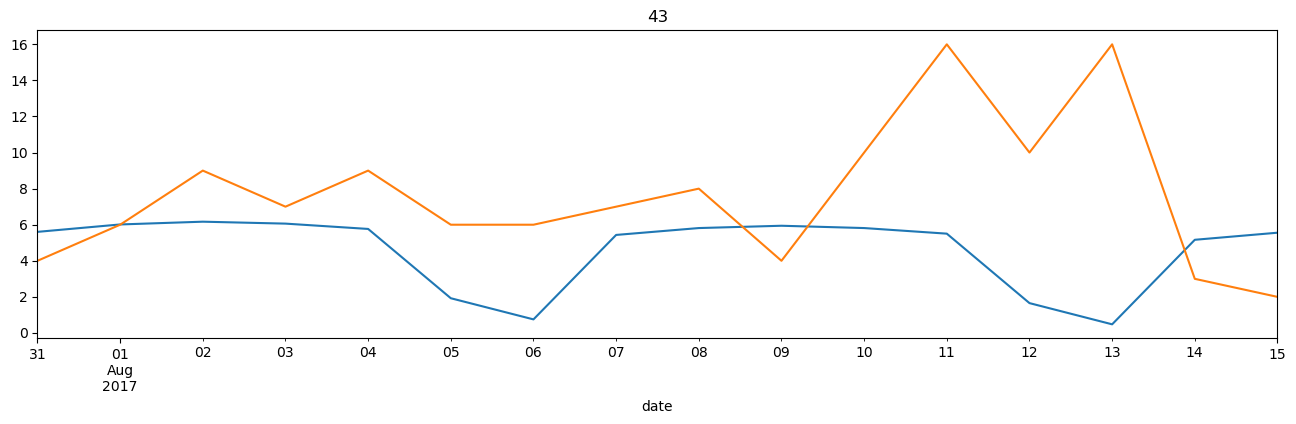

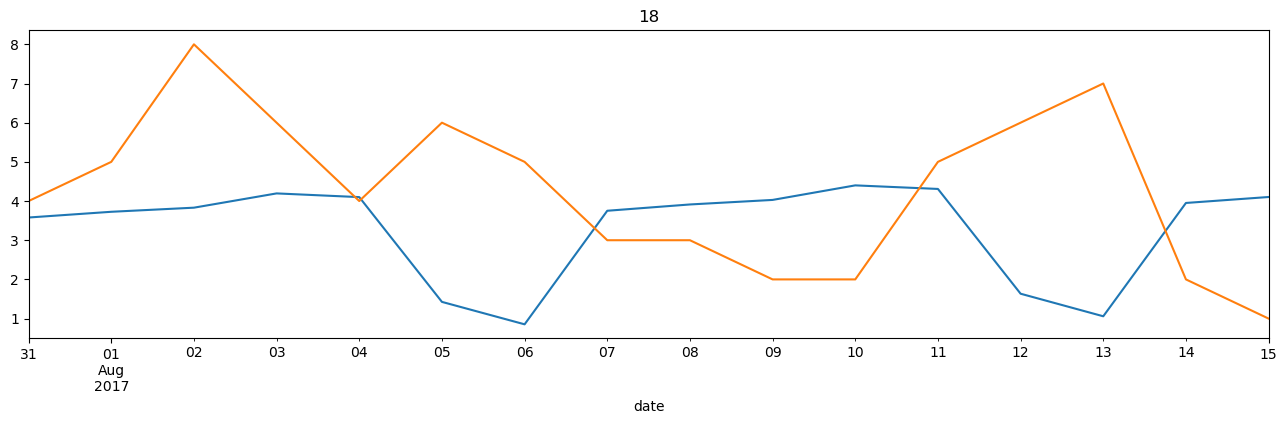

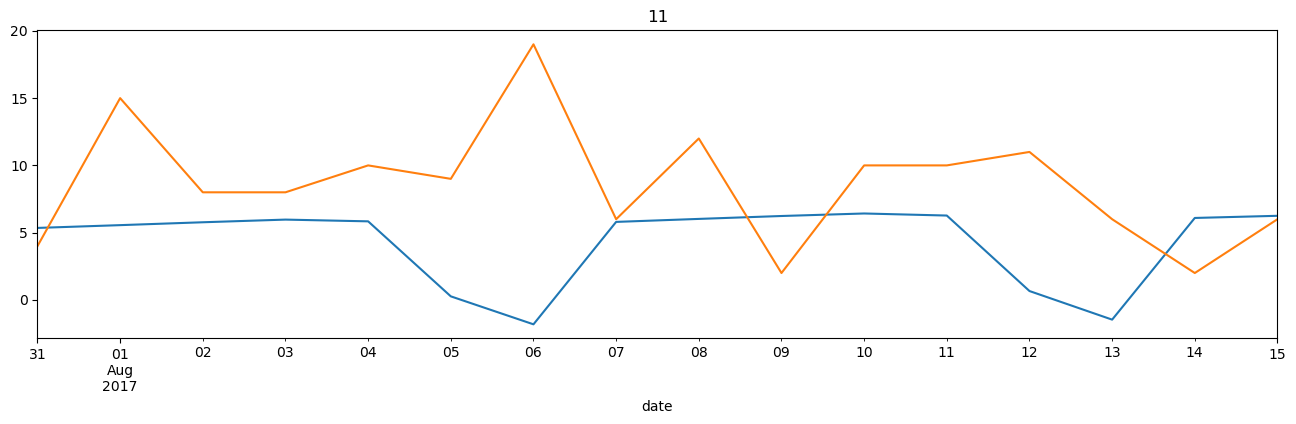

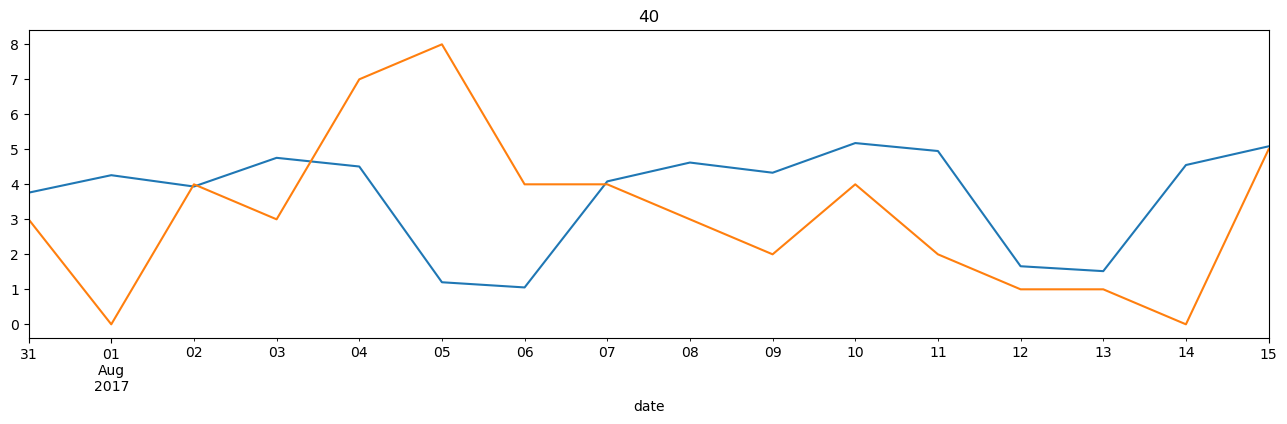

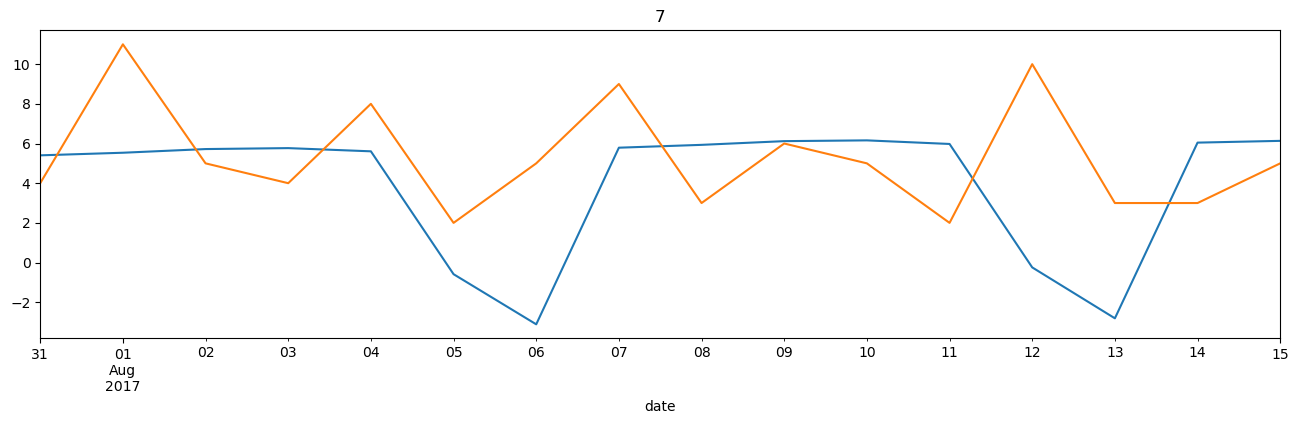

In [140]:
for col in sample:
    if col != 'total':
        ax = adjusted_preds.loc[validation_dataMatrix.index.min():validation_dataMatrix.index.max(), col].plot()
        validation_dataMatrix[col].plot(ax=ax)
        ax.set_title(col)
        plt.show()

In [65]:
import pandas as pd
import numpy as np
from hts import HTSRegressor

days = pd.date_range(pd.to_datetime('2020-01-01'), pd.to_datetime('2022-12-31'), freq='W')

df = pd.DataFrame(np.random.randint(0,100,size=(len(days),12)), columns=['a_x_1', 'a_x_2',
                                                                    'a_y_1', 'a_y_2',
                                                                    'b_x_1', 'b_x_2',
                                                                    'b_y_1', 'b_y_2',
                                                                    'c_x_1', 'c_x_2',
                                                                    'c_y_1', 'c_y_2'])
df['a_x'] = df['a_x_1'] + df['a_x_2']
df['a_y'] = df['a_y_1'] + df['a_y_2']
df['b_x'] = df['b_x_1'] + df['b_x_2']
df['b_y'] = df['b_y_1'] + df['b_y_2']
df['c_x'] = df['c_x_1'] + df['c_x_2']
df['c_y'] = df['c_y_1'] + df['c_y_2']
df['a'] = df['a_x'] + df['a_y']
df['b'] = df['b_x'] + df['b_y']
df['c'] = df['c_x'] + df['c_y']
df['total'] = df['a'] + df['b'] + df['c']
df['date'] = days
df = df.set_index('date')

hier = {'total': ['a', 'b', 'c'],
            'a': ['a_x', 'a_y'],
            'b': ['b_x', 'b_y'],
            'c': ['c_x', 'c_y'],
            'a_x': ['a_x_1', 'a_x_2'],
            'a_y': ['a_y_1', 'a_y_2'],
            'b_x': ['b_x_1', 'b_x_2'],
            'b_y': ['b_y_1', 'b_y_2'],
            'c_x': ['c_x_1', 'c_x_2'],
            'c_y': ['c_y_1', 'c_y_2']
        }

In [69]:
model_bu_prophet = HTSRegressor(model='prophet', revision_method='BU', n_jobs=0)
model_bu_prophet = model_bu_prophet.fit(df, hier, show_warnings=False)
pred_bu_prophet = model_bu_prophet.predict(steps_ahead=52)

Fitting models:   0%|                                | 0/22 [00:00<?, ?it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
Fitting models:   9%|██▏                     | 2/22 [00:00<00:01, 16.89it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling

<AxesSubplot: xlabel='date'>

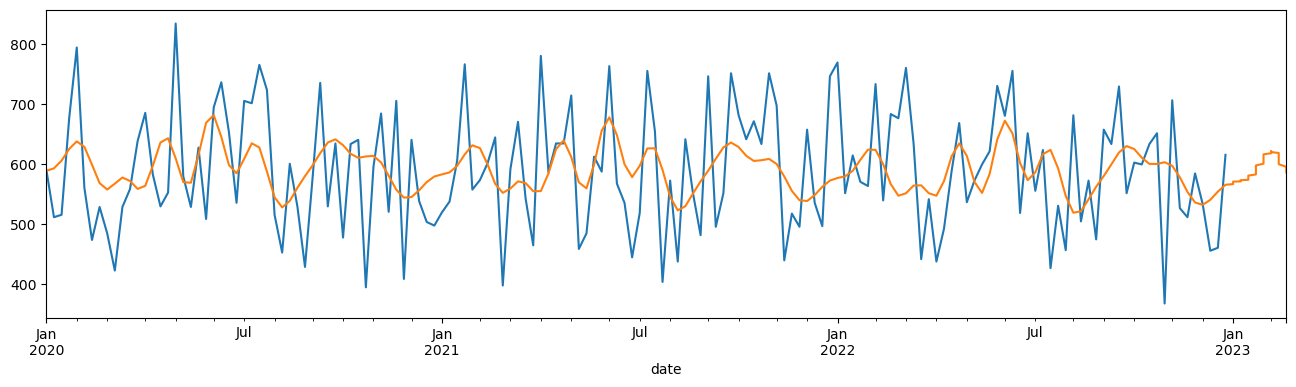

In [70]:
col = 'total'
ax = df[col].plot()
pred_bu_prophet[col].plot(ax=ax)

<AxesSubplot: xlabel='date'>

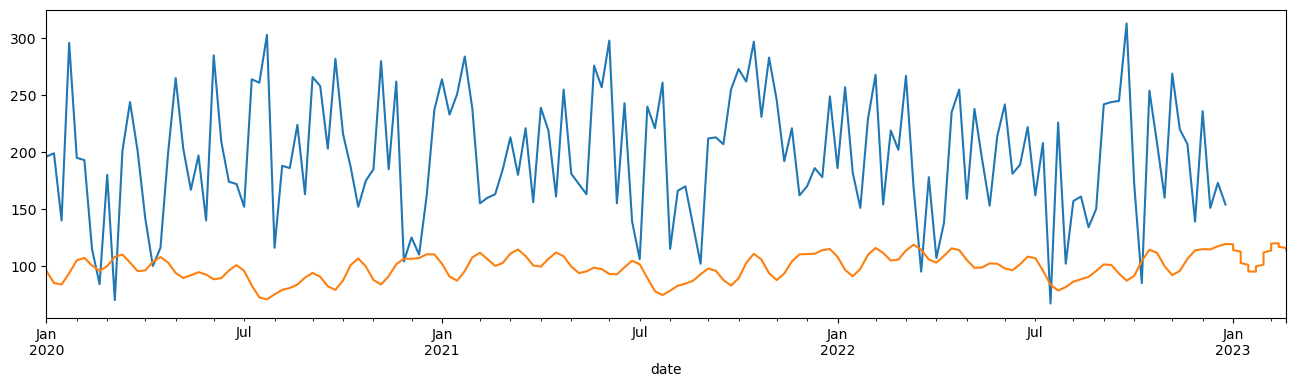

In [71]:
col = 'a'
ax = df[col].plot()
pred_bu_prophet[col].plot(ax=ax)

In [72]:
pred_bu_prophet

,total,a,b,c,a_x,a_y,b_x,b_y,c_x,c_y,...,a_y_1,a_y_2,b_x_1,b_x_2,b_y_1,b_y_2,c_x_1,c_x_2,c_y_1,c_y_2
2020-01-05,588.313470,95.791841,86.953302,88.076737,99.686782,110.926551,106.878257,182.745143,187.763519,217.804808,...,63.853822,47.072729,47.019076,52.667706,43.152425,44.924311,46.893035,40.060267,51.066984,44.724858
2020-01-12,592.508040,85.074819,86.684768,80.690896,119.806561,121.718109,98.532887,171.759587,200.497457,220.250996,...,60.635281,61.082828,63.130141,56.676420,46.479681,34.211214,48.799222,37.885546,40.532025,44.542794
2020-01-19,605.272219,83.706012,92.943641,82.091386,124.392324,121.231360,100.907495,176.649653,206.483710,222.138855,...,54.738325,66.493035,70.287787,54.104537,45.929598,36.161789,47.625434,45.318207,35.016500,48.689512
2020-01-26,624.827575,93.627833,106.592161,94.450412,108.135655,110.908777,111.112736,200.219994,202.586068,222.021513,...,46.982284,63.926493,61.475465,46.660190,42.357732,52.092680,46.932778,59.659383,40.724666,52.903167
2020-02-02,637.407710,104.966107,120.267398,110.443408,88.291974,95.517204,117.921619,225.233505,198.735382,213.438824,...,36.992555,58.524649,47.558489,40.733484,40.310271,70.133137,50.158904,70.108494,52.627586,52.338521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-11,603.551656,117.773832,124.244755,111.114182,68.477972,82.205005,99.735910,242.018587,179.592154,181.940915,...,22.238897,59.966109,37.594032,30.883939,40.108923,71.005260,60.717189,63.527566,77.409304,40.364528
2023-02-12,599.394134,116.838556,122.952645,110.040639,71.061054,80.399372,98.101868,239.791201,181.101694,178.501240,...,21.884028,58.515344,38.658911,32.402143,40.370755,69.669885,61.190385,61.762260,77.352812,39.485744
2023-02-13,594.941697,115.806677,121.436523,108.669178,73.906553,78.707537,96.415227,237.243201,182.575731,175.122765,...,21.733476,56.974061,39.841898,34.064655,40.605769,68.063410,61.553969,59.882554,77.128729,38.677948
2023-02-14,590.260982,114.715020,119.726765,107.029183,76.937195,77.142334,94.710484,234.441785,183.966378,171.852818,...,21.794816,55.347518,41.088820,35.848375,40.805869,66.223314,61.799264,57.927501,76.753835,37.961184
